# GradCAM - Gradient Class Activation Map

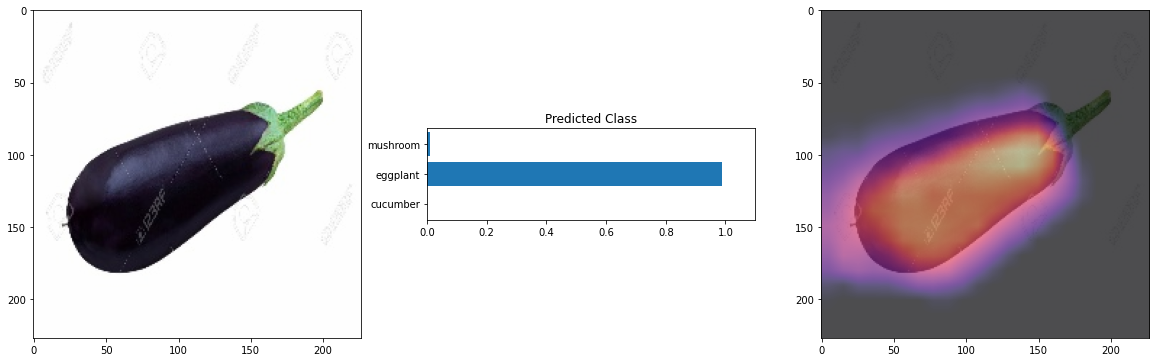

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 33.12 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ggwnvht7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ggwnvht7
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [7]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [9]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [10]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_augs = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Image Dataset

In [11]:
trainset = utils.ImageDataset(train_df, augs=train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)

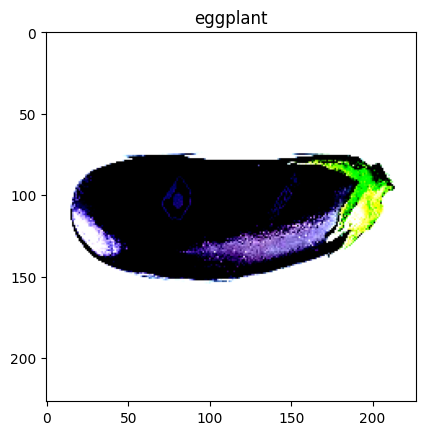

In [13]:
image, label = trainset[0]

class_list = ['cucumber', 'eggplant', 'mashroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [14]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [17]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [18]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [19]:
for images, labels in trainloader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

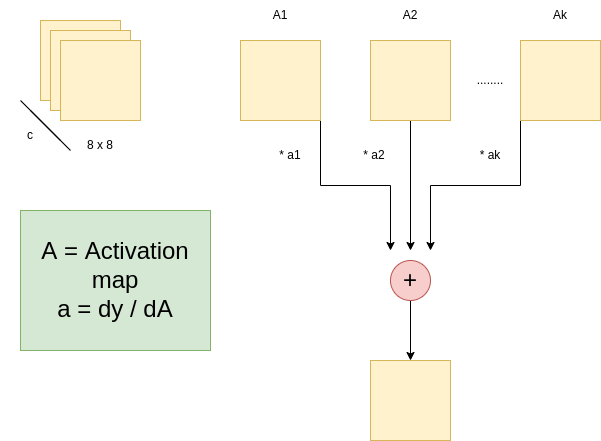

In [30]:
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, x):
        x = self.feature_extractor(x) # activation maps

        h = x.register_hook(self.activations_hook)

        x = self.maxpool(x)
        x = self.classifier(x)

        return x

    def get_activation_gradients(self):  # -> a1, a2, a3, ..., ak
        return self.gradient

    def get_activation(self, x):  # -> A1, A2, A3, ..., Ak
        return self.feature_extractor(x)  # 64 * 8 * 8

In [31]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [32]:
def train_fn(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [33]:
def eval_fn(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)

        loss = criterion(logits, labels)

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Training Loop

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader, model, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        best_valid_loss = valid_loss
        print('SAVED_WEIGHTS_SUCCESS')

    print(f'EPOCH : {i+1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}')

100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 1 TRAIN LOSS : 1.1024444282054902 VALID LOSS : 0.7543802062670389


100%|██████████| 3/3 [00:00<00:00, 34.23it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.5641988575458526 VALID LOSS : 0.5388540824254354


100%|██████████| 3/3 [00:00<00:00, 34.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 3 TRAIN LOSS : 0.26787336403504014 VALID LOSS : 0.4469698518514633


100%|██████████| 3/3 [00:00<00:00, 37.76it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 4 TRAIN LOSS : 0.2491312175989151 VALID LOSS : 0.09760576859116554


100%|██████████| 3/3 [00:00<00:00, 35.20it/s]


EPOCH : 5 TRAIN LOSS : 0.13744073137640953 VALID LOSS : 1.2937756131092708


100%|██████████| 3/3 [00:00<00:00, 37.40it/s]


EPOCH : 6 TRAIN LOSS : 0.9554176611825824 VALID LOSS : 0.26588163276513416


100%|██████████| 3/3 [00:00<00:00, 33.79it/s]


EPOCH : 7 TRAIN LOSS : 0.30519667863845823 VALID LOSS : 0.3536794036626816


100%|██████████| 3/3 [00:00<00:00, 39.57it/s]


EPOCH : 8 TRAIN LOSS : 0.19076566784642637 VALID LOSS : 0.1525168251246214


100%|██████████| 3/3 [00:00<00:00, 36.12it/s]


EPOCH : 9 TRAIN LOSS : 0.1184983316808939 VALID LOSS : 0.40954143305619556


100%|██████████| 3/3 [00:00<00:00, 36.96it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 10 TRAIN LOSS : 0.10280804298818111 VALID LOSS : 0.08489223352322976


100%|██████████| 3/3 [00:00<00:00, 34.98it/s]


EPOCH : 11 TRAIN LOSS : 0.05133523866534233 VALID LOSS : 0.3128567871948083


100%|██████████| 3/3 [00:00<00:00, 38.83it/s]


EPOCH : 12 TRAIN LOSS : 0.03584494219703629 VALID LOSS : 0.13021819883336624


100%|██████████| 3/3 [00:00<00:00, 39.88it/s]


EPOCH : 13 TRAIN LOSS : 0.01788499300832882 VALID LOSS : 0.2944770894634227


100%|██████████| 3/3 [00:00<00:00, 37.70it/s]


EPOCH : 14 TRAIN LOSS : 0.01378805770946201 VALID LOSS : 0.3240233357064426


100%|██████████| 3/3 [00:00<00:00, 39.08it/s]


EPOCH : 15 TRAIN LOSS : 0.011716557608451694 VALID LOSS : 0.3184757651761174


100%|██████████| 3/3 [00:00<00:00, 39.08it/s]


EPOCH : 16 TRAIN LOSS : 0.015405471857229713 VALID LOSS : 0.3712413287188004


100%|██████████| 3/3 [00:00<00:00, 33.45it/s]


EPOCH : 17 TRAIN LOSS : 0.01707072115241317 VALID LOSS : 0.5297409618118157


100%|██████████| 3/3 [00:00<00:00, 24.25it/s]


EPOCH : 18 TRAIN LOSS : 0.02113601220029295 VALID LOSS : 0.18228292664086135


100%|██████████| 3/3 [00:00<00:00, 24.87it/s]


EPOCH : 19 TRAIN LOSS : 0.013376142071547293 VALID LOSS : 0.504153463213394


100%|██████████| 3/3 [00:00<00:00, 25.54it/s]

EPOCH : 20 TRAIN LOSS : 0.191731029030052 VALID LOSS : 0.6611068081110716


# Get GradCAM

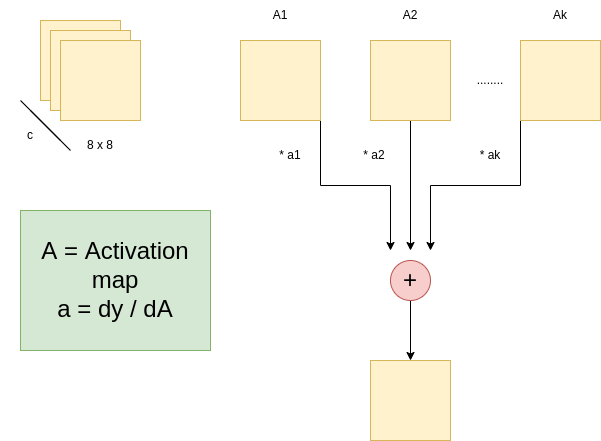

In [37]:
def get_gradcam(model, image, label, size):
    label.backward()

    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # a1, a2, ..., ak

    activations = model.get_activation(image).detach()  # A1, A2, ..., Ak

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))

    return heatmap

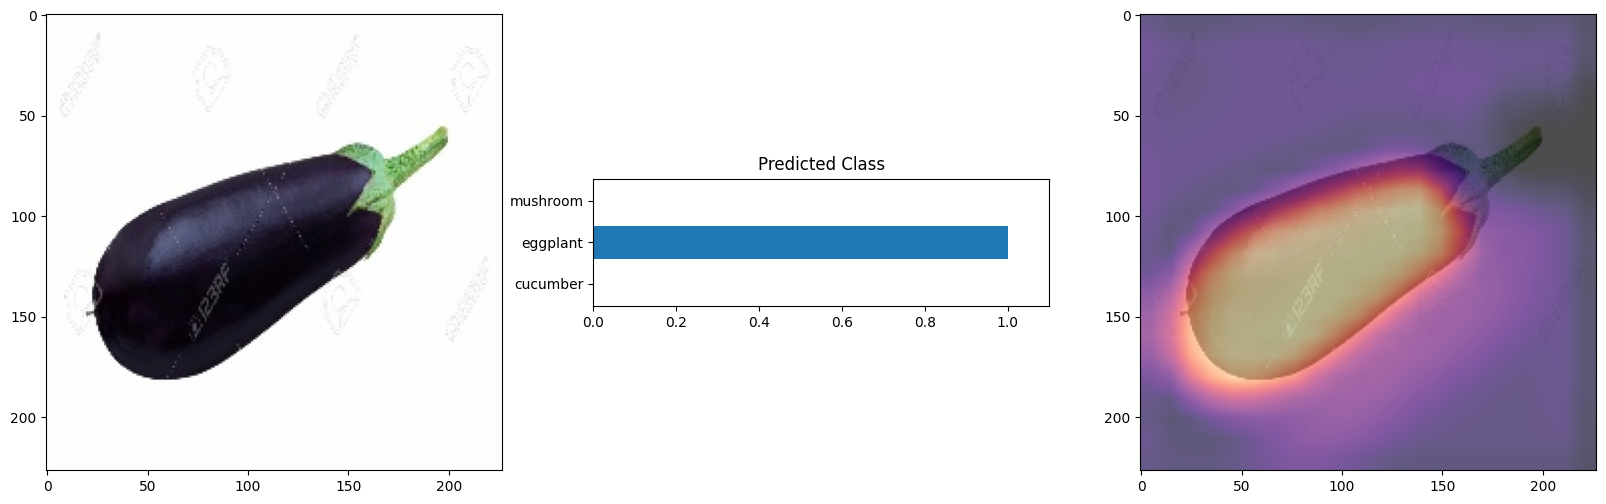

In [39]:
image, label = validset[4]

denom_image = image.permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size=227)
utils.plot_heatmap(denom_image, pred, heatmap)

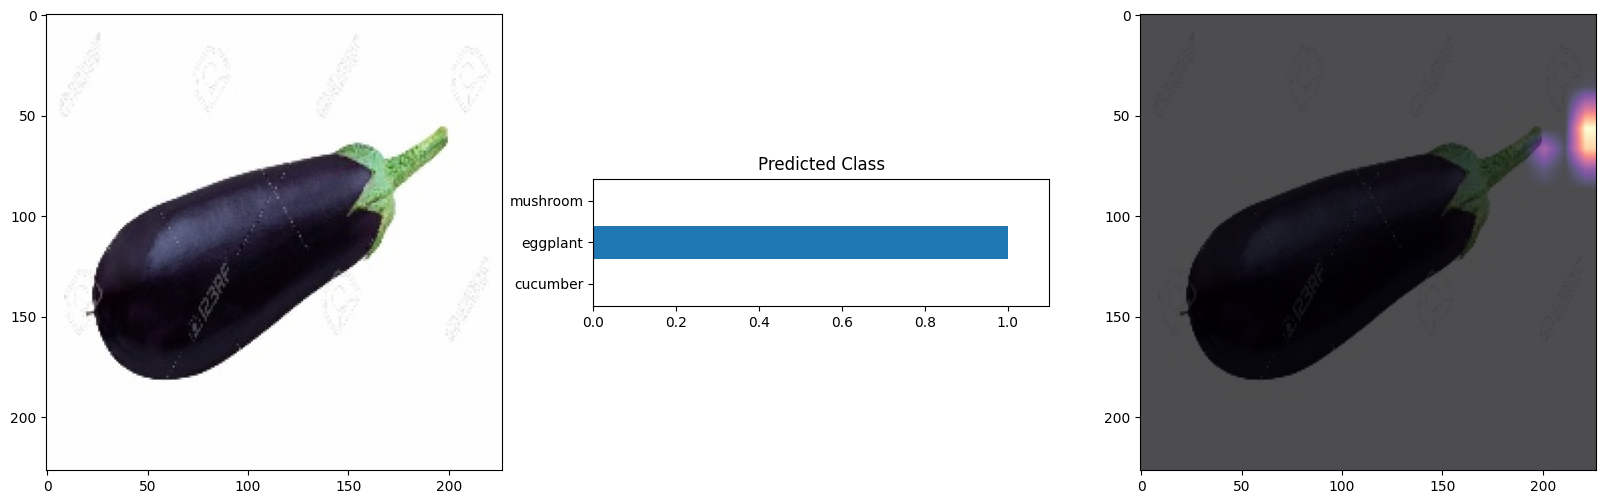

In [40]:
image, label = validset[4]

denom_image = image.permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size=227)
utils.plot_heatmap(denom_image, pred, heatmap)

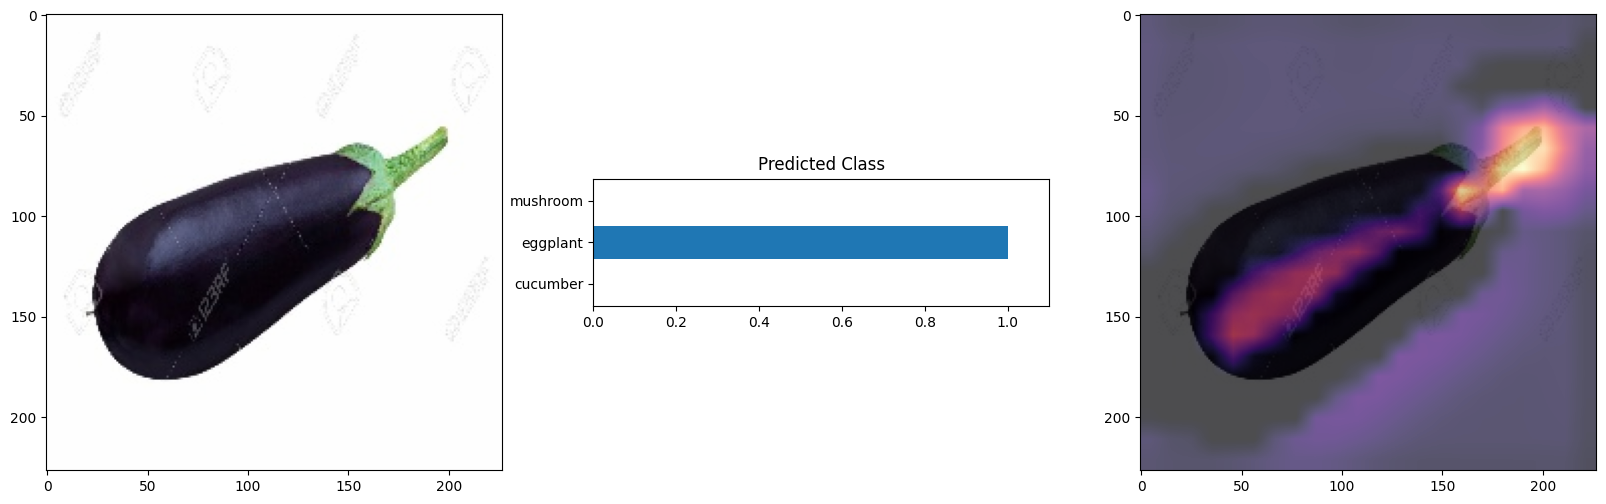

In [41]:
image, label = validset[4]

denom_image = image.permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][2], size=227)
utils.plot_heatmap(denom_image, pred, heatmap)